<a href="https://colab.research.google.com/github/danielhladky/CAS_ADS/blob/master/TP_single_hidden_layer_network_UniBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

## Predictive Inventory Management

### Authors: Daniel Hladky and Vadim Peshekhonov

Integrum Solution AG works on specific customer projects. Within this work the aim is to predict the inventory based on the historical consumption of data. The data has been already extracted and cleaned and are available in a CSV format. The aim is to get 2 years of historical data and to train two models (e.g. LSTM and GradientBoosting) that will give a simple view of the stock movement. The regression will be implemented in Keras or TensorFlow and Scikit-Learn.

Links to datasets you may use: Customer specific historical data as CSV The data will be kind of anonymous. Only UUID (individual stock within supply chain is shown withut customer name)

Date: 19 February 2019 (project presentation at UniBE)

## Module 3 - UniBE - CAS Applied Data Science
For the module 3 we have elaborated on various aspects and created different notebooks within Colab or jupyter notebooks. 

### Part I   -  Data Analysis, XGB, Lasso, Ridge(Time_series_analysis_TP_UniBE.ipynb)
### Part II  -  TensorFlow (TF) LSTM  (BAG_TP_ML_DL_UniBE.ipynb)
### Part III -  TF single hidden layer (TP_single_hidden_layer_network_UniBE.ipynb)
### Part IV -  TF FullyConnected_MultiLayer(multiple_layer_network_TP_UniBE.ipynb)

# Implementing a one-layer Neural Network


We will illustrate how to create a one hidden layer NN

Input: Thermoplan mean aggr data with 85 columns as features to predict  one single variable

In [0]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
from sklearn.preprocessing import StandardScaler

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

In [0]:
ops.reset_default_graph()

In [0]:
# use this code cell to mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read the file from google drive 
TP = '/content/drive/My Drive/Datasets_ML/Thermoplan_Mean_Agg_pushed.csv'
#TP = '/content/drive/My Drive/Thermoplan_aggregiertes_Dataframe.csv'
Thermoplan = pd.read_csv(TP)

In [0]:
#Was not able to access the data after mounting the drive. Used this code
Thermoplan = pd.read_csv('Thermoplan_Mean_Agg_pushed.csv')

# Use the following UUID's for testing
uuid = '026CBAE094394E01A29914AF256DD413'
uuid = 'CAC59BCDBE86370D840726487D717367'
uuid = '8C5BBAAB7A213D69885122F2BF3E986C'

In [0]:
#column name to forecast - predict a UUID - provide 2-3 potential UUID's
column_name3 = 'CAC59BCDBE86370D840726487D717367'
column_name2 = '026CBAE094394E01A29914AF256DD413'
column_name1 = '8C5BBAAB7A213D69885122F2BF3E986C'


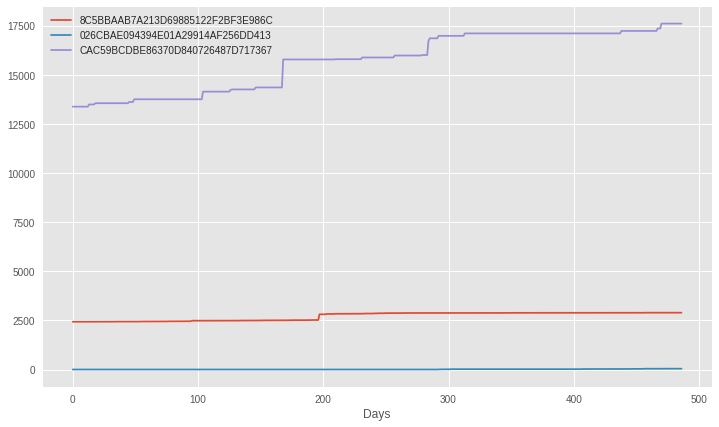

In [0]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.xlabel('Days')
plt.plot(Thermoplan[column_name1].values, label=column_name1)
plt.plot(Thermoplan[column_name2].values, label=column_name2)
plt.plot(Thermoplan[column_name3].values, label=column_name3)
plt.legend()
plt.show()

In [0]:
#DF Shape: 487 rows, 768 columns
#UUIDS: 682 (y labels to be predicted)
number_of_features = 85

In [0]:
#Prepare features only dataset
Features=Thermoplan
cyclo=1
while cyclo <= 768-number_of_features:
   
    Features = Features.drop(Features.columns[[0]], axis=1)
    cyclo +=1

In [0]:
x_vals=Features.values
y_vals = Thermoplan[column_name1].values

In [0]:
# Create graph session 
sess = tf.Session()
tf.set_random_seed(2)
np.random.seed(2)  

In [0]:
# Split into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), int(round(len(x_vals)*0.8)), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [0]:
# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [0]:
#Declare batch size and initialize placeholders
batch_size = 5
x_data = tf.placeholder(shape=[None, number_of_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [0]:
# Create variables for both NN layers
hidden_layer_nodes = number_of_features
A1 = tf.Variable(tf.random_normal(shape=[number_of_features,hidden_layer_nodes])) # inputs -> hidden nodes
b1 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes]))   # one biases for each hidden node
A2 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes,1])) # hidden inputs -> 1 output
b2 = tf.Variable(tf.random_normal(shape=[1]))   # 1 bias for the output


# Declare model operations
hidden_output = tf.nn.relu(tf.add(tf.matmul(x_data, A1), b1))
final_output = tf.nn.relu(tf.add(tf.matmul(hidden_output, A2), b2))

# Declare loss function (MSE)
loss = tf.reduce_mean(tf.square(y_target - final_output))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(loss)

In [0]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
test_loss = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(np.sqrt(temp_loss))
    
    test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_loss.append(np.sqrt(test_temp_loss))
    if (i+1)%50==0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))

Generation: 50. Loss = 6907353.5
Generation: 100. Loss = 7917007.0
Generation: 150. Loss = 6566889.0
Generation: 200. Loss = 7049410.5
Generation: 250. Loss = 6544917.5
Generation: 300. Loss = 6970142.5
Generation: 350. Loss = 7418797.0
Generation: 400. Loss = 6879322.5
Generation: 450. Loss = 6928035.0
Generation: 500. Loss = 7454025.0


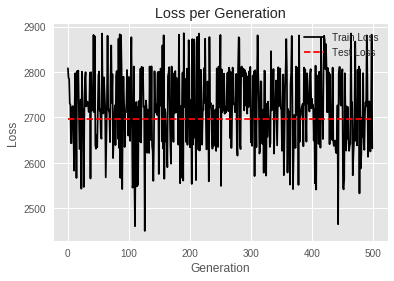

In [0]:
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

#2.  Implementing a one-layer Neural Network


We will illustrate how to create a x hidden layer NN

Input: One single valiable historic data 

In [0]:
#May be skiped if already run before
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
from sklearn.preprocessing import StandardScaler

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [0]:
#Was not able to access the data after mounting the drive. Used this code

Thermoplan = pd.read_csv('Thermoplan_Mean_Agg_pushed.csv')
#column name to forecast - predict a UUID - provide 2-3 potential UUID's
column_name3 = 'CAC59BCDBE86370D840726487D717367'
column_name2 = '026CBAE094394E01A29914AF256DD413'
column_name1 = '8C5BBAAB7A213D69885122F2BF3E986C'
data = Thermoplan[column_name1].values

In [0]:
window_size = 20
x_vals = []
y_vals = []
    
i = 0
while (i + window_size) <= len(data)-1:
    x_vals.append(list(data[i:i+window_size]))
    y_vals.append(data[i+window_size])
    i += 1



In [0]:
x_vals=np.array(x_vals)
y_vals=np.array(y_vals)

In [0]:
# Create graph session 
sess = tf.Session()
tf.set_random_seed(2)
np.random.seed(2)  

In [0]:
# Split into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), int(round(len(x_vals)*0.8)), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [0]:
# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [0]:
#Declare batch size and initialize placeholders
batch_size = 5
x_data = tf.placeholder(shape=[None, window_size], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [0]:
# Create variables for both NN layers
hidden_layer_nodes = 7
A1 = tf.Variable(tf.random_normal(shape=[window_size,hidden_layer_nodes])) # inputs -> hidden nodes
b1 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes]))   # one biases for each hidden node
A2 = tf.Variable(tf.random_normal(shape=[hidden_layer_nodes,1])) # hidden inputs -> 1 output
b2 = tf.Variable(tf.random_normal(shape=[1]))   # 1 bias for the output


# Declare model operations
hidden_output = tf.nn.relu(tf.add(tf.matmul(x_data, A1), b1))
final_output = tf.nn.relu(tf.add(tf.matmul(hidden_output, A2), b2))

# Declare loss function (MSE)
loss = tf.reduce_mean(tf.square(y_target - final_output))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(loss)

In [0]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
test_loss = []
for i in range(2000):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(np.sqrt(temp_loss))
    
    test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_loss.append(np.sqrt(test_temp_loss))
    if (i+1)%50==0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))

Generation: 50. Loss = 6902516.0
Generation: 100. Loss = 7360501.0
Generation: 150. Loss = 7418073.5
Generation: 200. Loss = 7846994.5
Generation: 250. Loss = 7887031.0
Generation: 300. Loss = 7313721.5
Generation: 350. Loss = 6891773.0
Generation: 400. Loss = 7840581.5
Generation: 450. Loss = 7036938.5
Generation: 500. Loss = 7840549.5
Generation: 550. Loss = 7877818.5
Generation: 600. Loss = 7817214.5
Generation: 650. Loss = 7333046.5
Generation: 700. Loss = 7842755.0
Generation: 750. Loss = 7887050.5
Generation: 800. Loss = 7439421.0
Generation: 850. Loss = 6528203.5
Generation: 900. Loss = 7010693.5
Generation: 950. Loss = 6987715.0
Generation: 1000. Loss = 7811769.0
Generation: 1050. Loss = 7011096.0
Generation: 1100. Loss = 7457251.0
Generation: 1150. Loss = 7448961.0
Generation: 1200. Loss = 7880951.0
Generation: 1250. Loss = 7779741.5
Generation: 1300. Loss = 7051133.5
Generation: 1350. Loss = 7358697.5
Generation: 1400. Loss = 7891313.0
Generation: 1450. Loss = 7053386.5
Gener

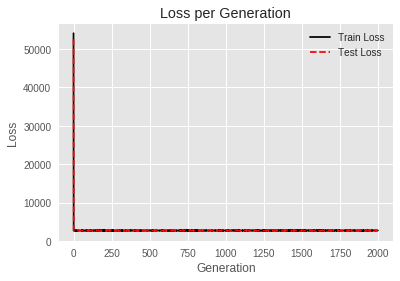

In [0]:
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()